In [1]:
##training data formatting code
import statsmodels as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [33]:
x = pd.read_csv('/Users/andrewslottje/Documents/x.csv', parse_dates=True)
x = x.rename(columns={"[TimeStamp]":"Timestamp"})
y = pd.read_csv('/Users/andrewslottje/Documents/y.csv', parse_dates=True)

In [27]:
#create new variables for stationarity
x.index = pd.DatetimeIndex(x.Timestamp)
x['ETHspread_d']=np.log(x['ETHspread']/x['ETHspread'].shift(1))
x['ETHvolume_d']=np.log(x['ETHvolume']/x['ETHvolume'].shift(1))
x.loc[x.ETHvolume_d.isnull(),'ETHvolume_d']=0.0
x.loc[x.ETHspread_d.isnull(),'ETHspread_d']=0.0
x['ETHreturnindicator']=np.sign(x['ETHreturn'])
x=x[~x.isnull()]
data = x[['ETHreturn','ETHspread_d','ETHvolume_d','XRPreturn','LTCreturn','DASHreturn','XMRreturn','ETHreturnindicator']]

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


In [28]:
#fit VAR and do feature selection
model=VAR(data)
#model.select_order(50)
results = model.fit(3)
data['ETHpredict']=results.fittedvalues['ETHreturn']
data['ETHreturn_resid']=(data['ETHreturn']-results.fittedvalues['ETHreturn'])
data['ETHpredict']=data['ETHpredict'].shift(1)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [59]:
#generate lagged data
for i in ['ETHreturn','ETHspread_d','ETHvolume_d','XRPreturn','LTCreturn','DASHreturn','XMRreturn','ETHreturn_resid']:
#for i in ['ETHreturn','ETHspread_d','ETHvolume_d','XRPreturn','LTCreturn','DASHreturn','XMRreturn']:
    #generate 10 lags of data
    for j in range(1,10):
        data[str(i)+"_l"+str(j)]=data[str(i)].shift(j)

data=data.drop(['ETHreturnindicator'],axis=1)
data['ETHreturnindicator']=0.0
data.loc[data.ETHreturn>.005,'ETHreturnindicator']=1.0
data['ETHreturnindicator']=data['ETHreturnindicator'].shift(-1)
#drop nan rows
data=data.drop(data.index[0:14])
data=data.drop(data.index[-1:])

In [12]:
#for reasons as yet unknown, scaling actually reduces effectiveness for our problem
#for i in data.columns.values[:-1]:
#    data[i]=MinMaxScaler(feature_range=(-1, 1)).fit_transform(data[i])

In [32]:
#data.to_csv('/Users/andrewslottje/Documents/train_x.csv')
#data.to_csv('/Users/andrewslottje/Documents/train_x_noresid.csv')
data.to_csv('/Users/andrewslottje/Documents/train_x_10lags_005.csv')

In [30]:
#check response variable balance
len(data[data['ETHreturnindicator']==1])/len(data)

0.30852329945985535

In [60]:
#correlation table
x = pd.read_csv('/Users/andrewslottje/Documents/x.csv', parse_dates=True)
x = x.rename(columns={"[TimeStamp]":"Timestamp"})
new_x = x[['ETHreturn','XRPreturn','LTCreturn','DASHreturn','XMRreturn']]
for i in ['ETHreturn','XRPreturn','LTCreturn','DASHreturn','XMRreturn']:
    for j in range(12,20):
        new_x[str(i)+"_"+str(j)+"lags"]=new_x[str(i)].shift(j)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


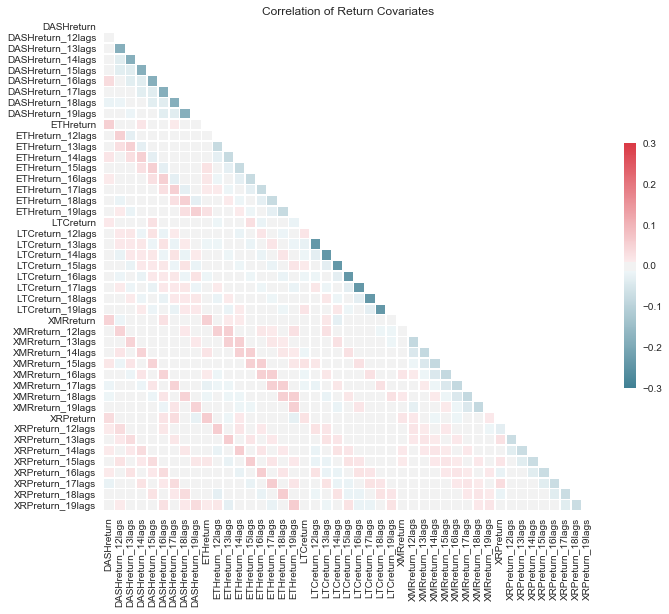

In [61]:
#correlation plot 
#code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
import seaborn as sns
new_x = new_x.reindex_axis(sorted(new_x.columns), axis=1)
sns.set(style="white")

# Compute the correlation matrix
corr = new_x.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation of Return Covariates')
plt.show()